In [ ]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score

In [ ]:
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = None

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://drive.google.com/file/d/1ce1aWNzV7OADyMbwvwBSV0VJgiq7SqoR/view?usp=share_link

In [ ]:
daily = pd.read_csv('/content/drive/MyDrive/Upwork/finxter/cronometer/daily_final.csv')
foods = pd.read_csv('/content/drive/MyDrive/Upwork/finxter/cronometer/daily_foods_final.csv')
apd = pd.read_csv('/content/drive/MyDrive/Upwork/finxter/cronometer/another_person_weight_measurements.csv')

## Create new features to help explore the data

In [ ]:
daily['caloric_deficit'] = 2056 - daily.total_calories
daily['day'] = range(1, len(daily) + 1)
daily.set_index('date', inplace=True)
daily['date'] = daily.index

daily['last_wk_weight'] = daily.shift(periods=7)['weight']
daily['yesterday_weight'] = daily.shift(periods=1)['weight']
daily['yesterday_total_calories'] = daily.shift(periods=1)['total_calories']
daily['daily_wt_loss'] = daily.yesterday_weight - daily.weight
daily['weekly_wt_loss'] = daily.last_wk_weight - daily.weight
daily['total_calories_7dma'] = daily['total_calories'].rolling(7).mean()
daily['total_calories_14dma'] = daily['total_calories'].rolling(14).mean()
daily['total_calories_21dma'] = daily['total_calories'].rolling(21).mean()

In [ ]:
daily.head()

,weight,total_calories,Carbs,Fiber,Net Carbs,Fat,Omega-3,Omega-6,Protein,Cystine,Histidine,Isoleucine,Leucine,Lysine,Methionine,Phenylalanine,Threonine,Tryptophan,Tyrosine,Valine,B1 (Thiamine),B2 (Riboflavin),B3 (Niacin),B5 (Pantothenic Acid),B6 (Pyridoxine),B12 (Cobalamin),Folate,Vitamin A,Vitamin C,Vitamin D,Vitamin E,Vitamin K,Calcium,Copper,Iron,Magnesium,Manganese,Phosphorus,Potassium,Selenium,Sodium,Zinc,exercise_calories,caloric_deficit,day,date,last_wk_weight,yesterday_weight,yesterday_total_calories,daily_wt_loss,weekly_wt_loss,total_calories_7dma,total_calories_14dma,total_calories_21dma
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-01,212.2,1941.8,133,144,131,41,201,45,50,66,100,129,92,78,80,157,145,139,120,121,106,75,149,140,226,41667,125,209,440,833,55,119,177,379,271,173,254,131,208,91,174,266,-84.87,114.2,1,2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-02,211.2,1934.9,126,211,115,34,260,42,58,81,130,139,107,95,89,191,166,143,103,140,142,89,104,119,283,3,166,75,371,0,93,295,237,676,307,294,369,160,230,120,177,82,-84.81,121.1,2,2021-04-02,NaN,212.2,1941.8,1.0,NaN,NaN,NaN,NaN
2021-04-03,210.8,2059.2,131,142,129,48,187,81,61,37,138,168,125,91,87,196,161,176,154,144,60,80,66,141,153,41674,55,129,363,834,31,155,227,321,397,149,296,126,135,177,128,268,-78.76,-3.2,3,2021-04-03,NaN,211.2,1934.9,0.4,NaN,NaN,NaN,NaN
2021-04-04,211.2,1924.4,140,258,124,19,84,11,57,68,132,145,117,107,83,205,145,141,89,143,53,72,67,93,190,5,125,60,216,178,72,433,170,509,336,211,325,162,204,133,240,72,-60.58,131.6,4,2021-04-04,NaN,210.8,2059.2,-0.4,NaN,NaN,NaN,NaN
2021-04-05,209.4,2216.6,164,233,154,36,93,14,55,60,111,116,91,88,74,170,131,156,113,119,108,111,93,95,251,41670,181,167,206,833,95,1238,161,392,345,257,430,127,192,94,138,271,-33.50,-160.6,5,2021-04-05,NaN,211.2,1924.4,1.8,NaN,NaN,NaN,NaN


## Helper functions

In [ ]:
def plot_regression(data, independent_var, dependent_var, title):
  y = data[dependent_var].values.reshape(-1, 1)
  X = data[independent_var].values.reshape(-1,1)

  model = LinearRegression()
  model.fit(X, y)
  slope = model.coef_[0][0]
  intercept = model.intercept_[0]
  y_pred = intercept + slope * X.reshape(-1)
  r2 = r2_score(data[dependent_var], y_pred)

  # plot
  plt.figure(figsize=(12,8))
  sns.scatterplot(x=independent_var, y=dependent_var, data=data)
  plt.plot(X.reshape(-1), y_pred, linewidth=1, color='r', label=f'y={slope:.2f} * x + {intercept:.1f}')
  plt.title(title + f'\nr2 = {r2:.2f} ')
  plt.legend()
  plt.show()


def correlation_heatmap(df, title):
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    # love the shrink here!
    sns.heatmap(corr, mask=mask, cmap='BuPu', center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot=True)
    plt.title(title)
    plt.show()

## Correlations between features

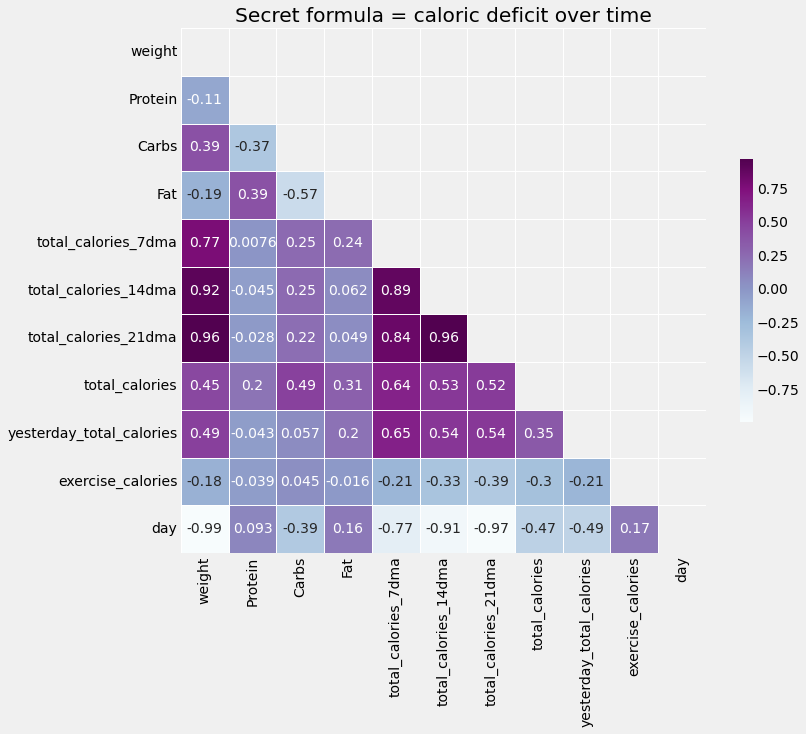

In [ ]:
df = daily[['weight', 'Protein', 'Carbs', 'Fat', 'total_calories_7dma', 'total_calories_14dma', 'total_calories_21dma',
           'total_calories', 'yesterday_total_calories', 'exercise_calories', 'day']]
correlation_heatmap(df, 'Secret formula = caloric deficit over time')

## Overall the weight loss was quite linear

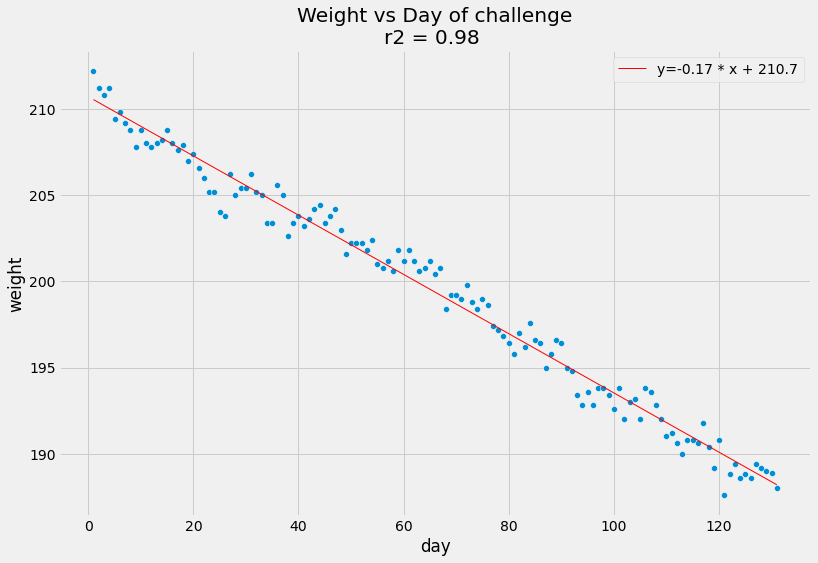

In [ ]:
plot_regression(daily, 'day', 'weight', 'Weight vs Day of challenge')

Maybe my eyes are playing tricks on me, but it almost looks like there is a hint of a small wave weaving it's way around the regression line. The weight loss looks like it was much more rapid in the first week and a half, hit a point of resistance, went back up then resumed a more rapid pace. So for the first 3 weeks the weight loss was more rapid even though the caloric deficits were lower.

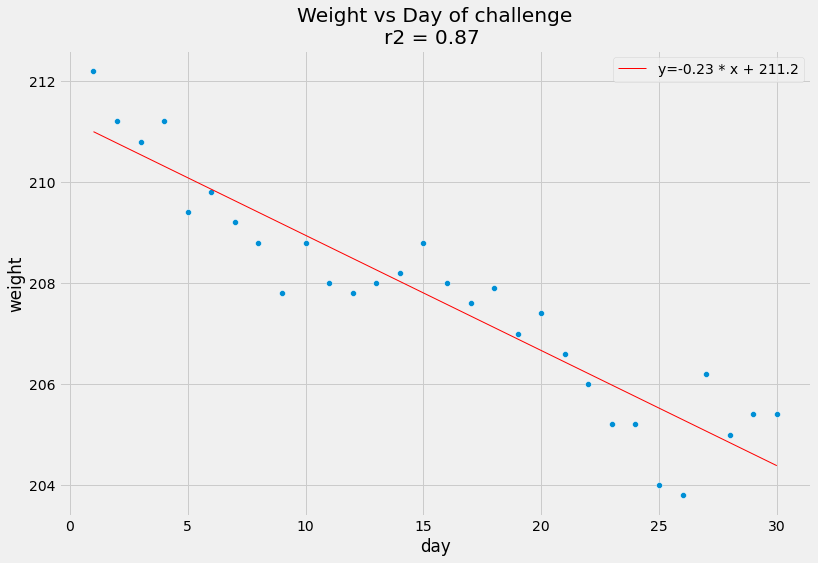

In [ ]:
plot_regression(daily.query('day < 31'), 'day', 'weight', 'Weight vs Day of challenge')

Looking at just the first month, it does appear that the weight loss was faster initially.

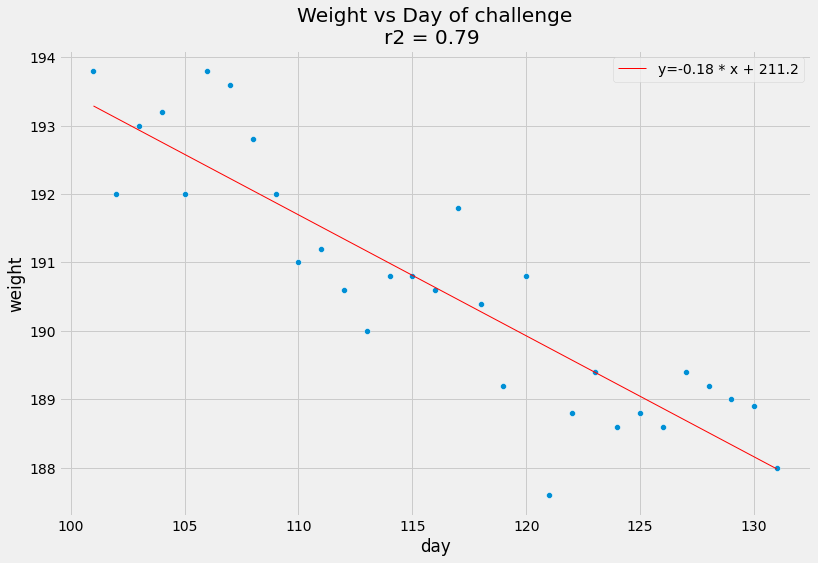

In [ ]:
plot_regression(daily.query('day > 100'), 'day', 'weight', 'Weight vs Day of challenge')

The final month looks about the same as the overall average.

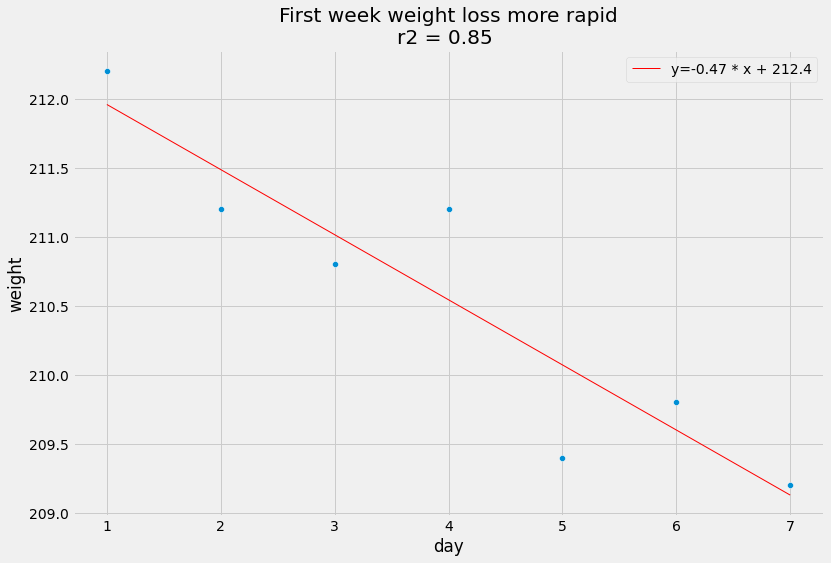

In [ ]:
plot_regression(daily.query('day < 8'), 'day', 'weight', 'First week weight loss more rapid')

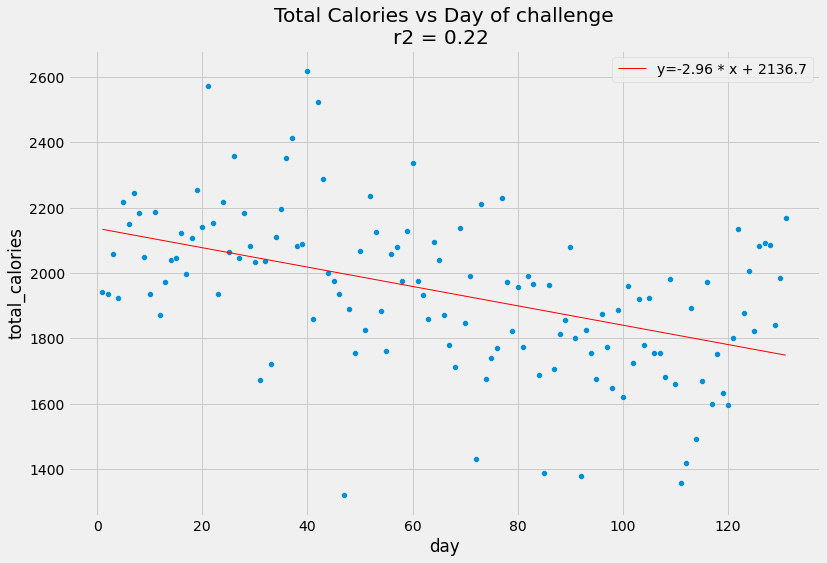

In [ ]:
plot_regression(daily, 'day', 'total_calories', 'Total Calories vs Day of challenge')

22% of the variation in total calories can be explained by number of days into the challenge. I got better at eating less as the challenge wore on. Perhaps this counteracted a natural tendency for the weight loss to level off as time wore on.

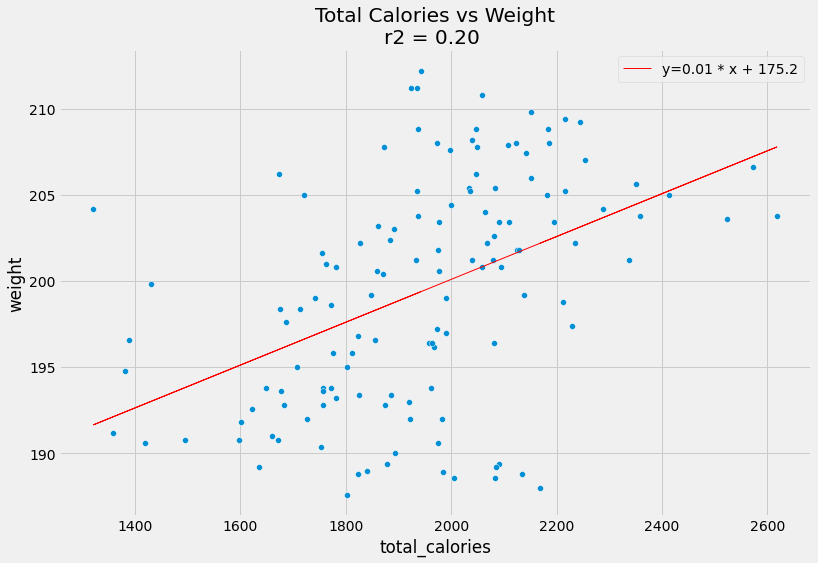

In [ ]:
plot_regression(daily, 'total_calories', 'weight', 'Total Calories vs Weight')

The graph of Total Calories vs Weight again seems to show more the effect of eating less as the challenge wore on.

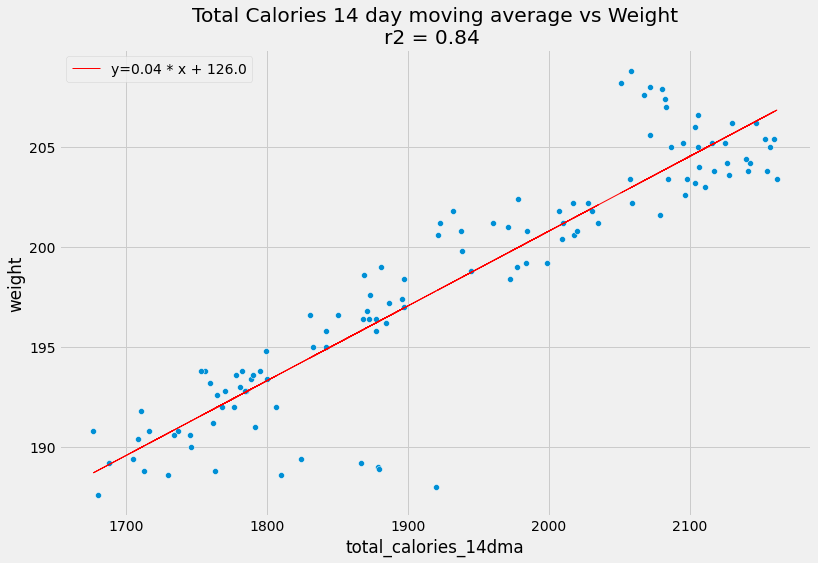

In [ ]:
plot_regression(daily[daily.total_calories_14dma.notnull()], 'total_calories_14dma', 'weight', 'Total Calories 14 day moving average vs Weight')

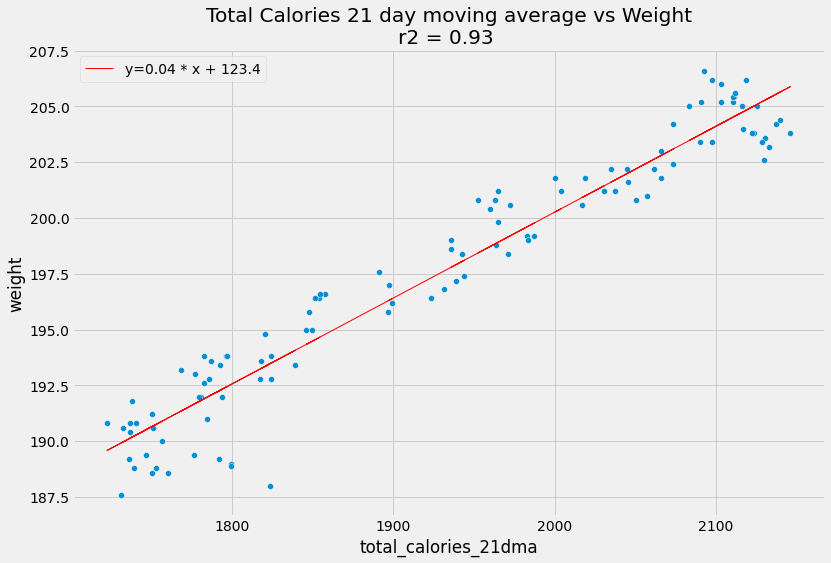

In [ ]:
plot_regression(daily[daily.total_calories_21dma.notnull()], 'total_calories_21dma', 'weight', 'Total Calories 21 day moving average vs Weight')

I interpret this as meaning it's the long term average that matters.

In [ ]:
daily.day.max()

131

In [ ]:
daily.weight[-1] - daily.weight[0]

-24.19999999999999

In [ ]:
daily.weight.describe()

count    131.000000
mean     199.367939
std        6.582918
min      187.600000
25%      193.500000
50%      200.600000
75%      204.700000
max      212.200000
Name: weight, dtype: float64

In [ ]:
daily.columns

Index(['weight', 'total_calories', 'Carbs', 'Fiber', 'Net Carbs', 'Fat',
       'Omega-3', 'Omega-6', 'Protein', 'Cystine', 'Histidine', 'Isoleucine',
       'Leucine', 'Lysine', 'Methionine', 'Phenylalanine', 'Threonine',
       'Tryptophan', 'Tyrosine', 'Valine', 'B1 (Thiamine)', 'B2 (Riboflavin)',
       'B3 (Niacin)', 'B5 (Pantothenic Acid)', 'B6 (Pyridoxine)',
       'B12 (Cobalamin)', 'Folate', 'Vitamin A', 'Vitamin C', 'Vitamin D',
       'Vitamin E', 'Vitamin K', 'Calcium', 'Copper', 'Iron', 'Magnesium',
       'Manganese', 'Phosphorus', 'Potassium', 'Selenium', 'Sodium', 'Zinc',
       'exercise_calories', 'caloric_deficit', 'day', 'date', 'last_wk_weight',
       'yesterday_weight', 'yesterday_total_calories', 'daily_wt_loss',
       'weekly_wt_loss', 'total_calories_7dma', 'total_calories_14dma',
       'total_calories_21dma'],
      dtype='object')

In [ ]:
daily.daily_wt_loss.describe()

count    130.000000
mean       0.186154
std        0.913529
min       -2.400000
25%       -0.400000
50%        0.200000
75%        0.800000
max        3.200000
Name: daily_wt_loss, dtype: float64

## Histogram of weight loss

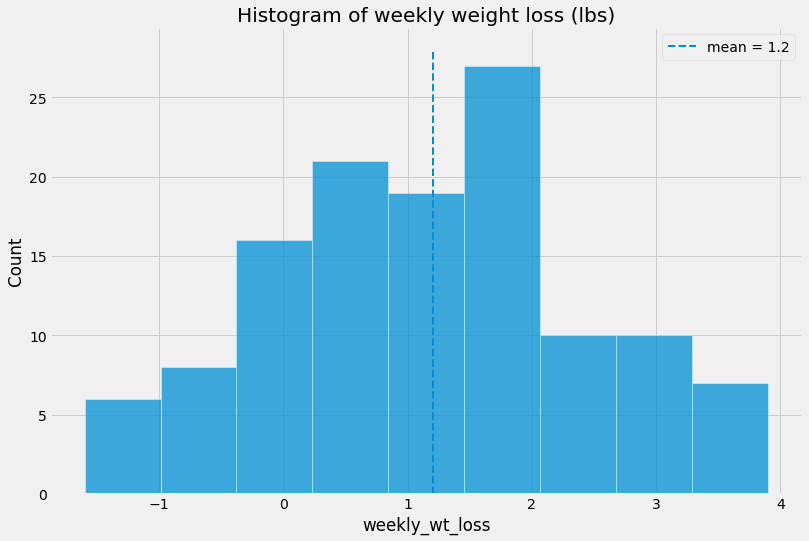

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(daily.weekly_wt_loss)
plt.title('Histogram of weekly weight loss (lbs)')
plt.plot([1.2, 1.2], [0, 28], '--', linewidth=2)
plt.legend(['mean = 1.2'])
plt.show()

95% of sample means are between 1.02 and 1.44


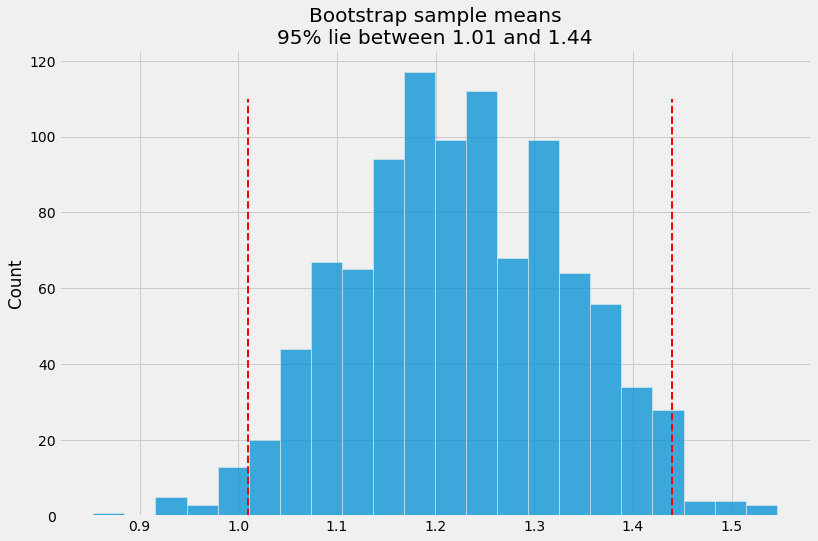

In [ ]:
n_straps = 1000
sample_means = []

for i in range(n_straps):
    sample = daily.sample(frac=1, replace=True)['weekly_wt_loss']
    sample_means.append(sample.mean())

means_sorted = sorted(sample_means)
left_idx = int(1000 * .025)
right_idx = int(1000 * .975)

print(f'95% of sample means are between {means_sorted[left_idx]:.2f} and {means_sorted[right_idx]:.2f}')

plt.figure(figsize=(12,8))
sns.histplot(sample_means)
plt.title('Bootstrap sample means\n95% lie between 1.01 and 1.44')
plt.plot([1.01, 1.01], [0,110], 'r--', linewidth=2, label='95% CI Lower Bound')
plt.plot([1.44, 1.44], [0,110], 'r--', linewidth=2, label='95% CI Upper Bound')
plt.show()


## Good days and Bad days
you know I've had my share

In [ ]:
bad_days = daily[daily.caloric_deficit < -100]
good_days = daily[daily.caloric_deficit > 100]

In [ ]:
bad_days.shape

(20, 54)

In [ ]:
20 / 131

0.15267175572519084

In [ ]:
good_days.shape

(64, 54)

## Most Nutritious Foods

In [ ]:
food_scores = foods[['date', 'item', 'quantity', 'calories']].copy()

for col in foods.columns[25:]:
    food_scores[col] = foods[col].apply(lambda x: min(x, 100))

food_scores['score'] = food_scores.loc[:,'B1 (Thiamine)':].sum(axis=1)

top_foods = food_scores[['item', 'score', 'calories']].drop_duplicates()
top_foods = top_foods[top_foods.calories > 10]
top_foods.sort_values(by='score', ascending=False)

top_foods['score_cal_adj'] = top_foods.score / (top_foods.calories)

In [ ]:
top_foods.groupby('item', as_index=False).mean()[['item', 'score_cal_adj']] \
    .sort_values(by='score_cal_adj', ascending=False)[:10]

,item,score_cal_adj
88,"Green Foods, Wheat Grass Shots",24.375000
8,"Baby Spinach, Raw",21.811594
25,"Bob's Red Mill, Nutritional Yeast, Large Flake",19.338583
192,"Spinach, Raw",19.005856
113,"Lettuce, Mixed Greens",18.557608
147,"Parsley, Fresh",16.851852
106,"Kale, Raw",16.326531
26,"Bok Choy, Raw",15.952252
65,"Dole, Salad Mix, Spring Mix & Baby Spinach Blend",15.750000
47,"Cilantro, Leaves, Raw",15.478261


## 1400 calorie days

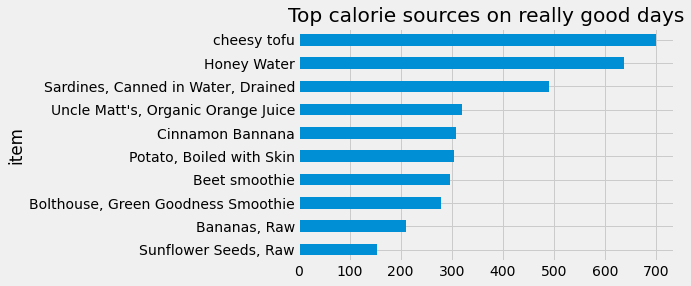

In [ ]:
lt_1400 = daily.query('total_calories < 1400').index
really_good_foods = foods[foods.date.isin(lt_1400)].groupby('item').agg({'calories': 'sum', 'item': 'count'})
really_good_foods.columns = ['total_calories', 'servings']
really_good_foods['calories_per_serving'] = really_good_foods.total_calories / really_good_foods.servings

really_good_bar = really_good_foods['total_calories'].sort_values(ascending=False)[:10]
really_good_bar.sort_values().plot.barh()
plt.title('Top calorie sources on really good days')
plt.show()

In [ ]:
daily.head()

,weight,total_calories,Carbs,Fiber,Net Carbs,Fat,Omega-3,Omega-6,Protein,Cystine,Histidine,Isoleucine,Leucine,Lysine,Methionine,Phenylalanine,Threonine,Tryptophan,Tyrosine,Valine,B1 (Thiamine),B2 (Riboflavin),B3 (Niacin),B5 (Pantothenic Acid),B6 (Pyridoxine),B12 (Cobalamin),Folate,Vitamin A,Vitamin C,Vitamin D,Vitamin E,Vitamin K,Calcium,Copper,Iron,Magnesium,Manganese,Phosphorus,Potassium,Selenium,Sodium,Zinc,exercise_calories,caloric_deficit,day,date,last_wk_weight,yesterday_weight,yesterday_total_calories,daily_wt_loss,weekly_wt_loss,total_calories_7dma,total_calories_14dma,total_calories_21dma
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-01,212.2,1941.8,133,144,131,41,201,45,50,66,100,129,92,78,80,157,145,139,120,121,106,75,149,140,226,41667,125,209,440,833,55,119,177,379,271,173,254,131,208,91,174,266,-84.87,114.2,1,2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-02,211.2,1934.9,126,211,115,34,260,42,58,81,130,139,107,95,89,191,166,143,103,140,142,89,104,119,283,3,166,75,371,0,93,295,237,676,307,294,369,160,230,120,177,82,-84.81,121.1,2,2021-04-02,NaN,212.2,1941.8,1.0,NaN,NaN,NaN,NaN
2021-04-03,210.8,2059.2,131,142,129,48,187,81,61,37,138,168,125,91,87,196,161,176,154,144,60,80,66,141,153,41674,55,129,363,834,31,155,227,321,397,149,296,126,135,177,128,268,-78.76,-3.2,3,2021-04-03,NaN,211.2,1934.9,0.4,NaN,NaN,NaN,NaN
2021-04-04,211.2,1924.4,140,258,124,19,84,11,57,68,132,145,117,107,83,205,145,141,89,143,53,72,67,93,190,5,125,60,216,178,72,433,170,509,336,211,325,162,204,133,240,72,-60.58,131.6,4,2021-04-04,NaN,210.8,2059.2,-0.4,NaN,NaN,NaN,NaN
2021-04-05,209.4,2216.6,164,233,154,36,93,14,55,60,111,116,91,88,74,170,131,156,113,119,108,111,93,95,251,41670,181,167,206,833,95,1238,161,392,345,257,430,127,192,94,138,271,-33.50,-160.6,5,2021-04-05,NaN,211.2,1924.4,1.8,NaN,NaN,NaN,NaN


In [ ]:
daily.Sodium

date
2021-04-01    174
2021-04-02    177
2021-04-03    128
2021-04-04    240
2021-04-05    138
             ... 
2021-08-07    128
2021-08-08    101
2021-08-09     62
2021-08-10     73
2021-08-11    139
Name: Sodium, Length: 131, dtype: int64

In [ ]:
foods.head()

,date,item,quantity,unit,calories,Energy,Water,Carbs,Fiber,Net Carbs,Fat,Omega-3,Omega-6,Protein,Cystine,Histidine,Isoleucine,Leucine,Lysine,Methionine,Phenylalanine,Threonine,Tryptophan,Tyrosine,Valine,B1 (Thiamine),B2 (Riboflavin),B3 (Niacin),B5 (Pantothenic Acid),B6 (Pyridoxine),B12 (Cobalamin),Folate,Vitamin A,Vitamin C,Vitamin D,Vitamin E,Vitamin K,Calcium,Copper,Iron,Magnesium,Manganese,Phosphorus,Potassium,Selenium,Sodium,Zinc
0,2021-04-01,Decaf,2.00,full recipe,75.28,3,19,5,5,5,2,0,0,1,2,1,1,1,0,0,2,0,0,1,1,0,8,13,0,0,0,0,0,0,0,1,0,3,9,3,7,4,3,9,2,5,1
1,2021-04-01,lemon water,2.00,full recipe,10.56,0,52,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,2,0,21,0,0,0,6,22,0,5,0,1,1,0,5,2
2,2021-04-01,Banana Protein Surprise,1.25,full recipe,411.86,18,3,36,21,38,2,2,0,9,6,11,4,4,3,3,6,22,4,5,9,5,11,10,19,60,0,8,1,72,0,1,1,51,168,65,69,78,8,53,20,19,7
3,2021-04-01,"Carrots, Cooked From Fresh",2.50,"medium - 6"" to 7"" long",52.50,2,4,5,15,3,0,0,0,1,13,4,6,4,4,3,6,15,4,4,4,8,5,6,7,14,0,5,142,6,0,10,17,5,3,6,4,10,6,10,2,6,3
4,2021-04-01,"Okra, Cooked from Fresh",1.00,"cup, sliced",35.20,2,4,3,13,1,0,0,0,2,4,4,7,5,4,4,7,6,6,10,7,18,7,9,7,18,0,18,3,29,0,3,53,12,15,6,14,20,7,6,1,1,6


In [ ]:
foods.Sodium

0        5
1        5
2       19
3        6
4        1
        ..
2089     0
2090     5
2091     0
2092     0
2093     7
Name: Sodium, Length: 2094, dtype: int64

## Sodium

In [ ]:
high_sodium_days = daily.query('Sodium > 200').index
daily.loc[high_sodium_days].shape

(10, 54)

Wow there were 30 days where I got more than 150% of the USRDA of sodium. And 10 days I got higher than 200%! What were the top calorie sources on days I got too much sodium?

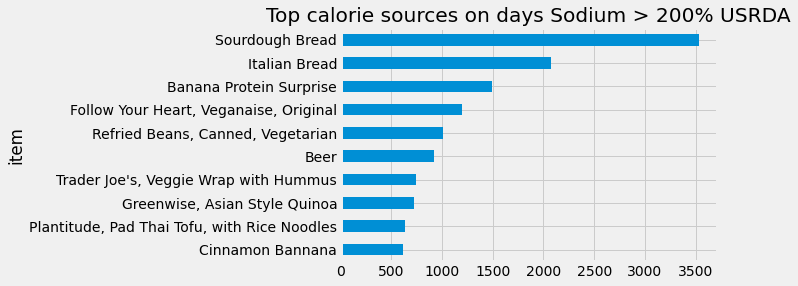

In [ ]:
high_sodium= daily.query('Sodium > 200').index
salty_foods = foods[foods.date.isin(high_sodium)].groupby('item').agg({'calories': 'sum', 'item': 'count'})
salty_foods.columns = ['total_calories', 'servings']
salty_foods['calories_per_serving'] = salty_foods.total_calories / salty_foods.servings

salty_bar = salty_foods['total_calories'].sort_values(ascending=False)[:10]
salty_bar.sort_values().plot.barh()
plt.title('Top calorie sources on days Sodium > 200% USRDA')
plt.show()

what foods are highest in sodium?

In [ ]:
foods.sort_values(by='Sodium', ascending=False)[['date', 'item', 'calories', 'Sodium']][:10]

,date,item,calories,Sodium
306,2021-04-21,Sourdough Bread,1598.29,236
525,2021-05-05,Sourdough Bread,1162.39,172
165,2021-04-12,"Refried Beans, Canned, Vegetarian",344.13,125
80,2021-04-06,"Refried Beans, Canned, Vegetarian",334.57,121
47,2021-04-04,"Refried Beans, Canned, Vegetarian",334.57,121
219,2021-04-15,Italian Bread,725.20,115
753,2021-05-22,Sourdough Bread,770.08,114
230,2021-04-16,"GreenWise, Organic, Tomato Basil Sauce",300.00,112
1496,2021-07-07,"Anchovy, Smoked, Canned in Oil and Drained",94.50,110
1425,2021-07-02,"Anchovy, Smoked, Canned in Oil and Drained",94.50,110


In [ ]:
foods.groupby('item').agg({'calories': 'mean', 'Sodium': 'mean'}).sort_values(by='Sodium', ascending=False).head(10)

,calories,Sodium
item,,
"Refried Beans, Canned, Vegetarian",337.756667,122.333333
"GreenWise, Organic, Tomato Basil Sauce",300.000000,112.000000
"Anchovy, Smoked, Canned in Oil and Drained",94.500000,110.000000
Sourdough Bread,687.627500,101.500000
"Trader Joe's, wrap, spicy lentil, with tahini sauce",1100.000000,96.000000
"Trader Giotto's, Mushroom Risotto",485.990000,93.000000
"Tropical Smoothie Cafe, Wrap, Hummus Veggie",710.000000,93.000000
"Nasoya, Udon, Teriyaki",400.000000,90.000000
"Trader Joe's, Chimichurri Rice With Vegetables",464.285714,88.428571


You're killin me Trader Joe! Basically all these are convenience foods that taste pretty good. The cost is too much sodium and calories. This brings to mind the old Jack Lalanne quote "If man makes it, don't eat it". And this other gem "If it tastes good spit it out".

## What about protein?

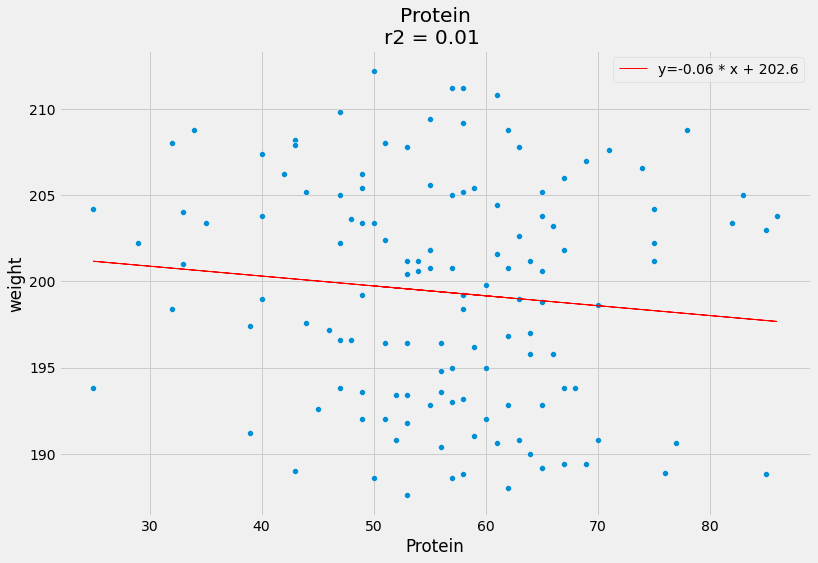

In [ ]:
plot_regression(daily, 'Protein', 'weight', 'Protein')

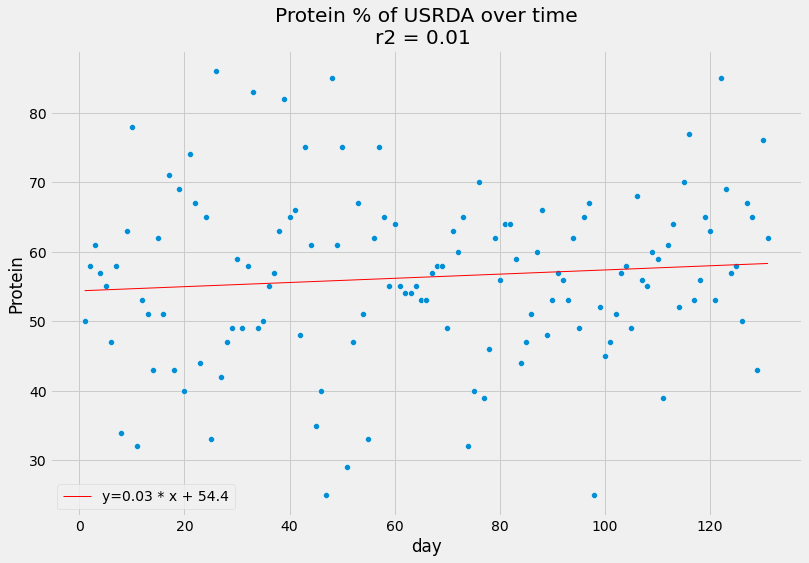

In [ ]:
plot_regression(daily, 'day', 'Protein', 'Protein % of USRDA over time')

Ok I'm pretty low in protein compared to the recommended amounts. I might look into adding more protein and see how I feel. The first thing I might try is to add some eggs to my diet.

## pareto

In [ ]:
daily.head()

,weight,total_calories,Carbs,Fiber,Net Carbs,Fat,Omega-3,Omega-6,Protein,Cystine,Histidine,Isoleucine,Leucine,Lysine,Methionine,Phenylalanine,Threonine,Tryptophan,Tyrosine,Valine,B1 (Thiamine),B2 (Riboflavin),B3 (Niacin),B5 (Pantothenic Acid),B6 (Pyridoxine),B12 (Cobalamin),Folate,Vitamin A,Vitamin C,Vitamin D,Vitamin E,Vitamin K,Calcium,Copper,Iron,Magnesium,Manganese,Phosphorus,Potassium,Selenium,Sodium,Zinc,exercise_calories,caloric_deficit,day,date,last_wk_weight,yesterday_weight,yesterday_total_calories,daily_wt_loss,weekly_wt_loss,total_calories_7dma,total_calories_14dma,total_calories_21dma
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-01,212.2,1941.8,133,144,131,41,201,45,50,66,100,129,92,78,80,157,145,139,120,121,106,75,149,140,226,41667,125,209,440,833,55,119,177,379,271,173,254,131,208,91,174,266,-84.87,114.2,1,2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-02,211.2,1934.9,126,211,115,34,260,42,58,81,130,139,107,95,89,191,166,143,103,140,142,89,104,119,283,3,166,75,371,0,93,295,237,676,307,294,369,160,230,120,177,82,-84.81,121.1,2,2021-04-02,NaN,212.2,1941.8,1.0,NaN,NaN,NaN,NaN
2021-04-03,210.8,2059.2,131,142,129,48,187,81,61,37,138,168,125,91,87,196,161,176,154,144,60,80,66,141,153,41674,55,129,363,834,31,155,227,321,397,149,296,126,135,177,128,268,-78.76,-3.2,3,2021-04-03,NaN,211.2,1934.9,0.4,NaN,NaN,NaN,NaN
2021-04-04,211.2,1924.4,140,258,124,19,84,11,57,68,132,145,117,107,83,205,145,141,89,143,53,72,67,93,190,5,125,60,216,178,72,433,170,509,336,211,325,162,204,133,240,72,-60.58,131.6,4,2021-04-04,NaN,210.8,2059.2,-0.4,NaN,NaN,NaN,NaN
2021-04-05,209.4,2216.6,164,233,154,36,93,14,55,60,111,116,91,88,74,170,131,156,113,119,108,111,93,95,251,41670,181,167,206,833,95,1238,161,392,345,257,430,127,192,94,138,271,-33.50,-160.6,5,2021-04-05,NaN,211.2,1924.4,1.8,NaN,NaN,NaN,NaN


In [ ]:
def get_status(row):
  if row['total_calories'] > 2100 and row['Sodium'] > 120:
    return 'salt and calories'
  elif row['total_calories'] > 2100:
    return 'calories'
  elif row['Sodium'] > 110:
    return 'sodium'
  else:
    return 'good'

daily['day_status'] = daily.apply(get_status, axis=1)

<AxesSubplot:xlabel='day_status'>

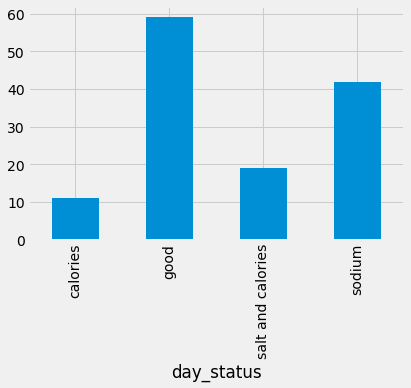

In [ ]:
daily.groupby('day_status').count()['weight'].plot.bar()

In [ ]:
6/7

0.8571428571428571